In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

Constants

In [2]:
b = 1e-4
g = 9.8
dt = 1e-1
Q = .1*np.eye(4)
R = 500*np.eye(2)
F = np.array(((1,0,dt,0),(0,1,0,dt),(0,0,1-b,0),(0,0,0,1-b)))
u = np.array((0,0,0,-g*dt))
w = la.cholesky(Q)
v = la.cholesky(R)
H = np.array(((1,0,0,0),(0,1,0,0)))

Problem 1

In [3]:
def model(x0,N):
    x = np.zeros((N,4))
    x[0] = x0
    for i in range(1,N):
        x[i] = F.dot(x[i-1]) + u + w.dot(np.random.rand(4))
    return x

X = model(np.array((0,0,300,600)),1200)
print X[-1]

[ 45009.42107298  10715.51982057    443.62517407   -405.77734257]


Problem 2

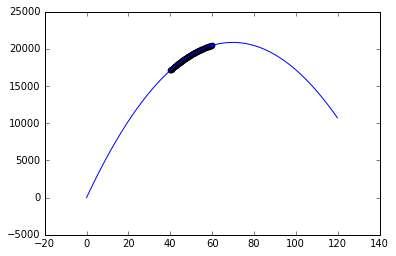

In [4]:
def measure(x):
    return H.dot(x) + v.dot(np.random.rand(2))

Y = np.array([measure(xk) for xk in X[400:600]])
T = np.arange(1200)*dt
plt.plot(T,X[:,1])
plt.scatter(T[400:600],Y[:,1])
plt.show()

Problem 3

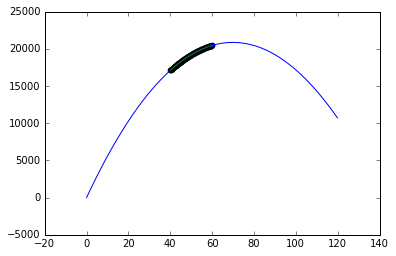

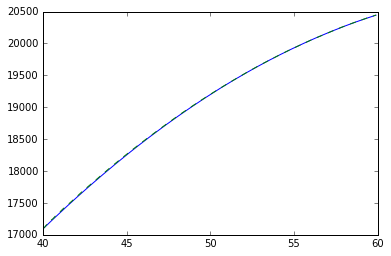

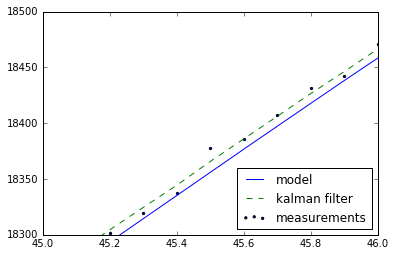

In [5]:
def kalman_filter(Y):
    P = 1e6 * Q
    X = np.zeros((Y.shape[0],4))    
    x = (Y[0,0],Y[0,1],
         np.diff(Y[:10,0]).mean(),np.diff(Y[:10,1]).mean())
    X[0] = x
    for i,y in enumerate(Y):
        
        P = F.dot(P).dot(F.T) + Q
        x = F.dot(x) + u
        K = P.dot(H.T).dot(la.inv(H.dot(P).dot(H.T) + R))
        x = x + K.dot(y - H.dot(x))
        P = (np.eye(4) - K.dot(H)).dot(P)
        
        X[i] = x
    return X,F.dot(P).dot(F.T) + Q

X_hat,Pm = kalman_filter(Y)
T = np.arange(1200)*dt
plt.plot(T,X[:,1])
plt.scatter(T[400:600],Y[:,1])
plt.plot(T[400:600],X_hat[:,1])
plt.show()

plt.plot(T[400:600],X[400:600,1])
#plt.scatter(T[400:600],Y[:,1],marker=".")
plt.plot(T[400:600],X_hat[:,1],linestyle="--")
plt.show()

plt.plot(T[400:600],X[400:600,1],label="model")
plt.scatter(T[400:600],Y[:,1],marker=".",label="measurements")
plt.plot(T[400:600],X_hat[:,1],label="kalman filter",linestyle="--")
plt.xlim(45,46)
plt.ylim(18300,18500)
plt.legend(loc=4)
plt.show()

Problem 4

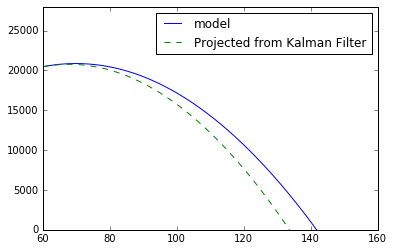

In [6]:
def kalman_filter_future(x0,P):
    X = []
    x = x0
    N = 0
    while True:
        P = F.dot(P).dot(F.T) + Q
        x = F.dot(x) + u
        X.append(x)
        N+=1
        if x[1] < 0:
            break
    return np.array(X),N

X_future,N = kalman_filter_future(X_hat[-1],Pm)
X2 = model(X[-1],801)
X_all = np.vstack((X,X2[1:]))
T = np.arange(2000)*dt

plt.plot(T[600:],X_all[600:,1],label="model")
plt.plot(T[600:600+N],X_future[:,1],
         label="Projected from Kalman Filter",linestyle="--")
plt.legend()
plt.xlim(60,160)
plt.ylim(0,28000)
plt.show()

The Kalman Filter got the end point reasonably correct

Problem 5

In [7]:
def inverse(xf):
    cross = 0
    x = xf
    invF = la.inv(F)
    while True:
        x = (invF.dot(x) - invF.dot(u) - 
            invF.dot(w.dot(np.random.rand(4))))
        if cross:
            if x[1] < 0:
                break
        elif x[1] > 0:
            cross = 1
    return x

print "From  Model"
print inverse(X_all[-1])
print "From Kalman Filter"
print inverse(X_future[-1])

From  Model
[-446.10317709   -1.94413446  293.59228466  609.15927398]
From Kalman Filter
[ 8889.50212679   -62.57703462   134.31758345   655.74410437]


Using the inverse algorithm neither get too close to the origin, but the model does better